# A4: Masked Auto-Encoder (MAE)

In this lab, we will develop masked auto encoder and experiment with them.

## Masked Auto-Encoder

The core idea is to randomly mask some patches and learn these from the remaining un-masked patches. There are several tricks used like deleting masked tokens to make the encoder lightweight and pre-train it in certain way. 

<img src="img/MAE.png" title="MAE - Original" style="width: 1080px;" />


The core-concept of SimMIM and MAE is the same. The only change is that masked patches are replaced with a trainable mask token at the input itself for SimMIM. For MAE, this is efficiently added directly to the decoder. This according to the paper improves the training time by 3x.

The idea is simple!

### Lets set up

In [ ]:
import random
import torch
import timm
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

import os
import argparse
import math
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor, Compose, Normalize
from tqdm import tqdm


In [ ]:
def setup_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Assuming normalization was (x - 0.5) / 0.5

## Patchify

### Input Preparation
1) Patching:
Imagine cutting an image into small squares, like tiles. Each tile (patch) is a small part of the image.
For example, if the image is 224x224 pixels, and each patch is 16x16 pixels, you get 196 patches (Like Vision Transformer in the previous lesson!)
Each patch carries a portion of the image’s information, like a zoomed-in section. 

### Masking
Now, randomly hide most of the patches – about 75%.
Only 25% of the patches are kept and passed to the next stage.
The hidden patches are completely ignored during this step.
This forces the model to learn how to "fill in the blanks" based on the small portion it can still see.



In [1]:
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

/home/jupyter-dsai-st123175/rtml_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter-dsai-st123175/rtml_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Encoder

The encoder only works with the visible patches. The hidden ones are not even seen by the encoder.
It treats the patches like "words" in a sentence. By looking at the pieces of the image, the encoder tries to understand what the overall image might represent.

To help the encoder keep track of the patch locations, a positional tag is added to each visible patch, like labeling each tile with its original position.

### Latent Space
After the encoder finishes processing, it produces a compressed version of the input.
This compressed version captures the key details from the visible patches, even though much of the image is missing.
Think of it like getting the gist of a puzzle just by looking at a few pieces.

In [ ]:
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.5,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))

        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(1, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        # print(img.size())
        patches = self.patchify(img)
        # print(patches.size())
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        # print(patches.size(), self.pos_embedding.size())
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes


## Decoder

The decoder takes the summary created by the encoder and attempts to reconstruct the entire image, filling in the missing patches.

To do this, the model uses a learned "placeholder" for the masked patches, and the decoder gradually tries to replace them with real content.

The model learns by comparing the reconstructed image to the original, and its goal is to minimize the difference between the two.

In [ ]:
class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim)) 

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 1 * patch_size ** 2) #3
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

## Masked Auto-Encoder

In [ ]:
class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()
        
        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask


## Set up parameters

In [5]:
seed = 42
batch_size = 256
max_device_batch_size = 512
base_learning_rate = 1.5e-4
weight_decay = 0.05
mask_ratio = 0.8
total_epoch = 10
warmup_epoch = 200
model_path = 'saved/vit-t-mae-mnist-lab.pt'

setup_seed(seed)

## Prepare data and model

In [6]:
from torch.utils.data import random_split
batch_size = batch_size
load_batch_size = min(max_device_batch_size, batch_size)

assert batch_size % load_batch_size == 0
steps_per_update = batch_size // load_batch_size

# train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=False, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
# val_dataset = torchvision.datasets.CIFAR10('data', train=False, download=False, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
dataset = torchvision.datasets.MNIST('data', train=True, download=False, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
# val_dataset = torchvision.datasets.MNIST('data', train=false, download=True, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))

# Split into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

dataloader = torch.utils.data.DataLoader(train_dataset, load_batch_size, shuffle=True, num_workers=4)
writer = SummaryWriter(os.path.join('logs', 'cifar10', 'mae-pretrain'))
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

model = MAE_ViT(image_size = 28, patch_size = 4, mask_ratio=mask_ratio).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=base_learning_rate * batch_size / 256, betas=(0.9, 0.95), weight_decay=weight_decay)
lr_func = lambda epoch: min((epoch + 1) / (warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / total_epoch * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

/home/jupyter-dsai-st123175/rtml_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Let's train!

100%|██████████| 188/188 [00:13<00:00, 13.63it/s]


In epoch 0, average traning loss is 0.5465917753729415.
=================== EPOCH:  1  ===================


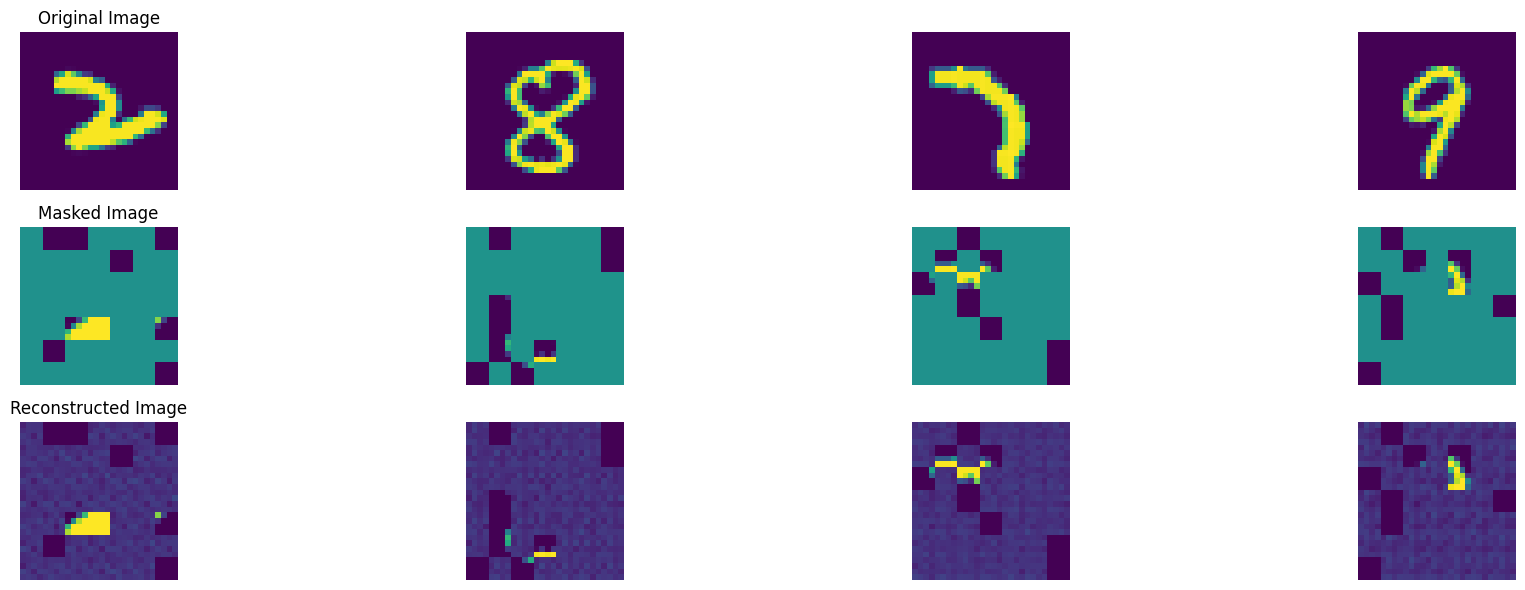

100%|██████████| 188/188 [00:13<00:00, 14.38it/s]


In epoch 1, average traning loss is 0.3796648606657982.
=================== EPOCH:  2  ===================


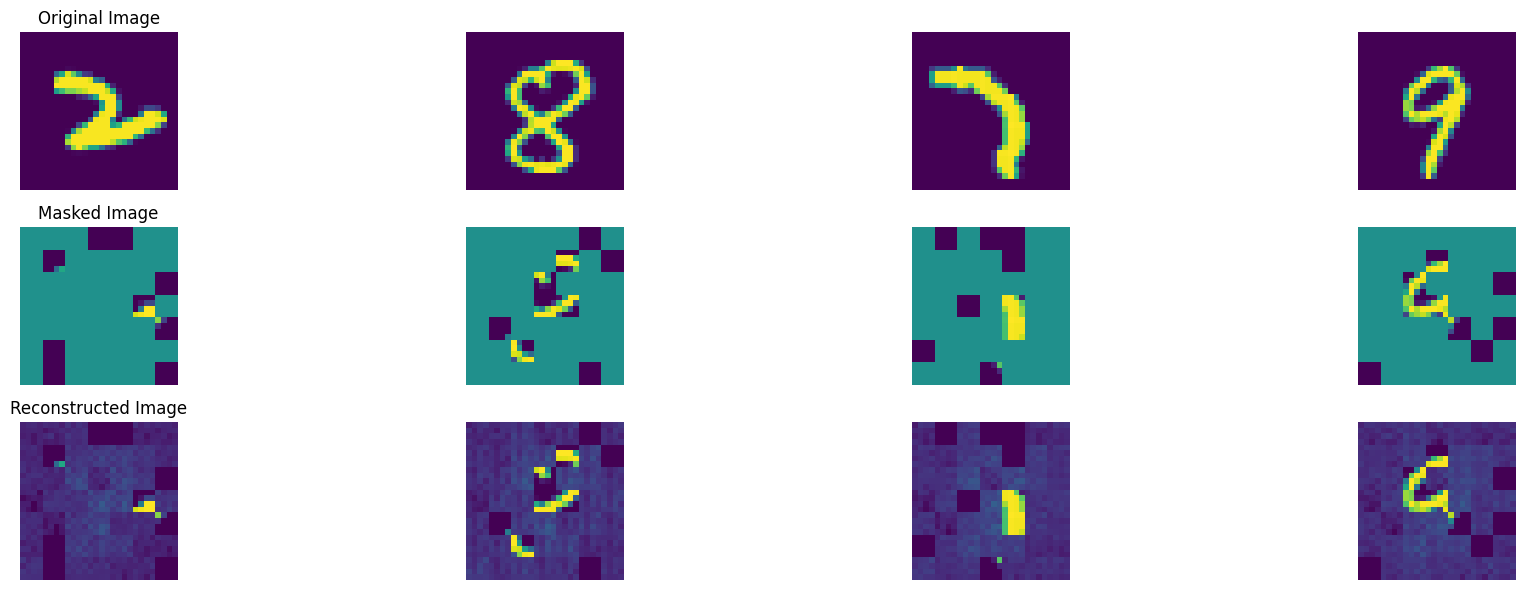

100%|██████████| 188/188 [00:13<00:00, 13.81it/s]


In epoch 2, average traning loss is 0.31179066192596516.
=================== EPOCH:  3  ===================


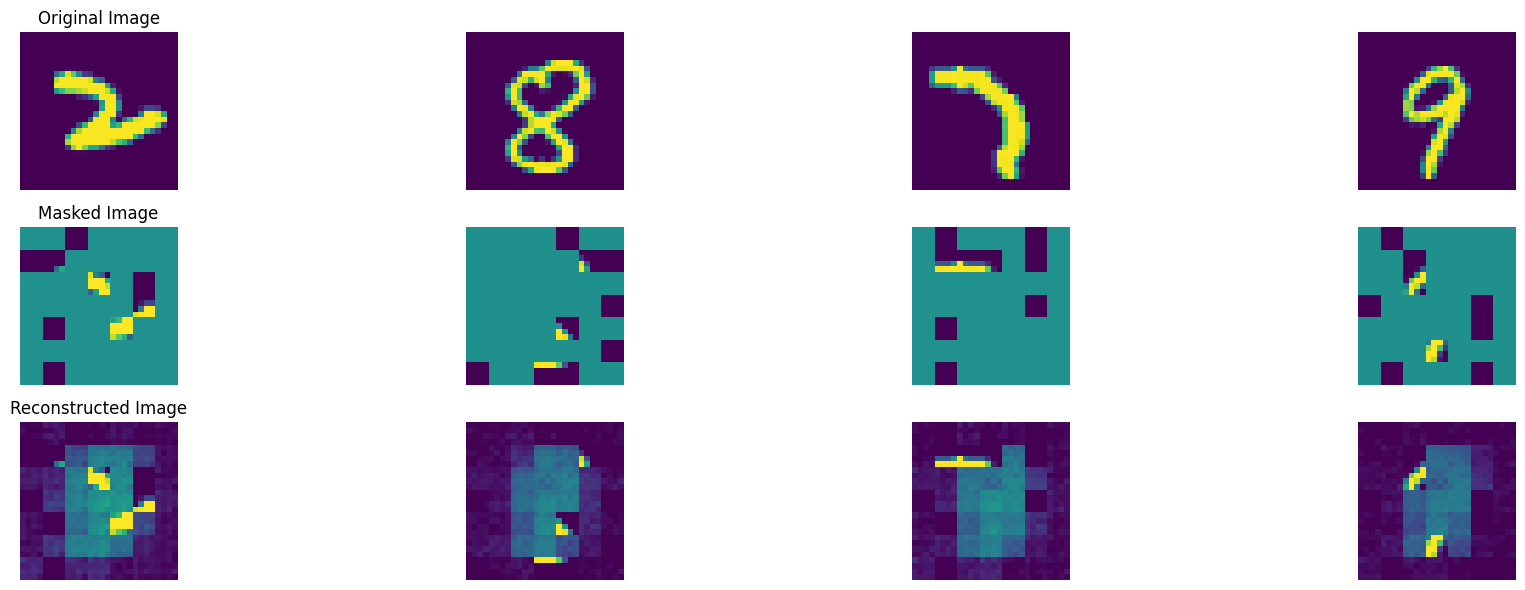

100%|██████████| 188/188 [00:13<00:00, 13.45it/s]


In epoch 3, average traning loss is 0.2802716832845769.
=================== EPOCH:  4  ===================


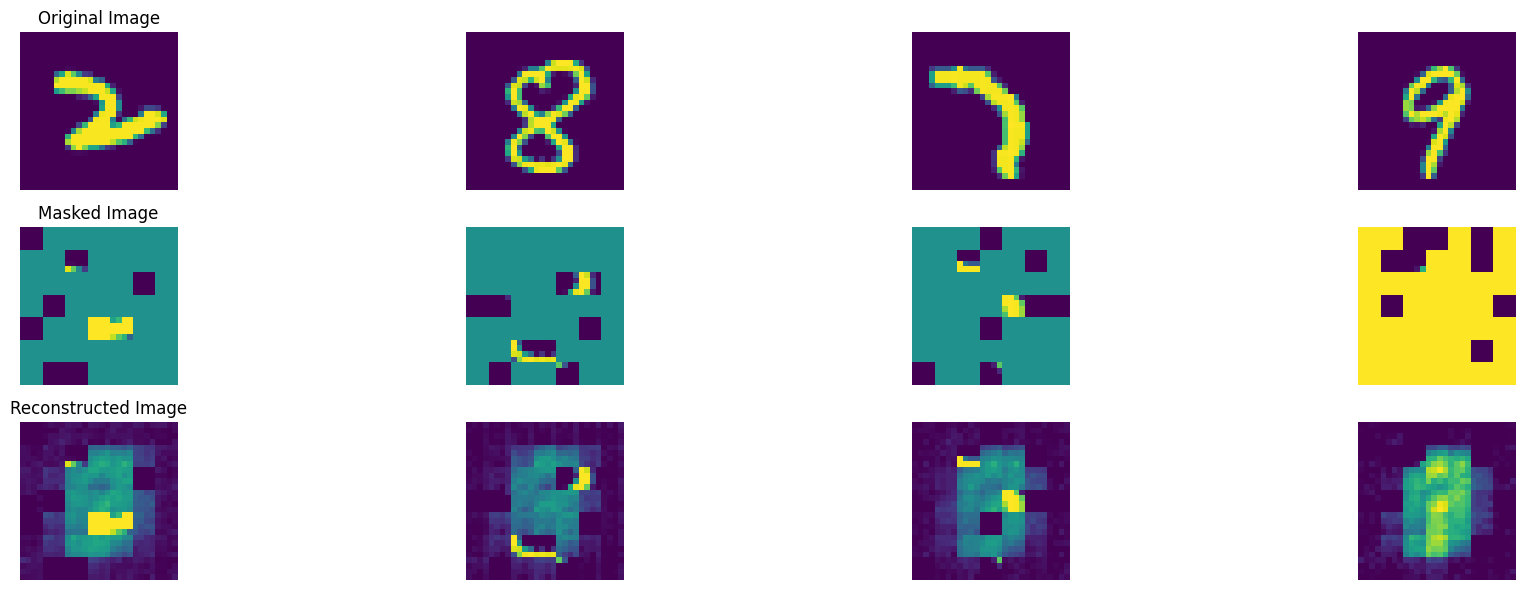

100%|██████████| 188/188 [00:13<00:00, 14.15it/s]


In epoch 4, average traning loss is 0.2737688419032604.
=================== EPOCH:  5  ===================


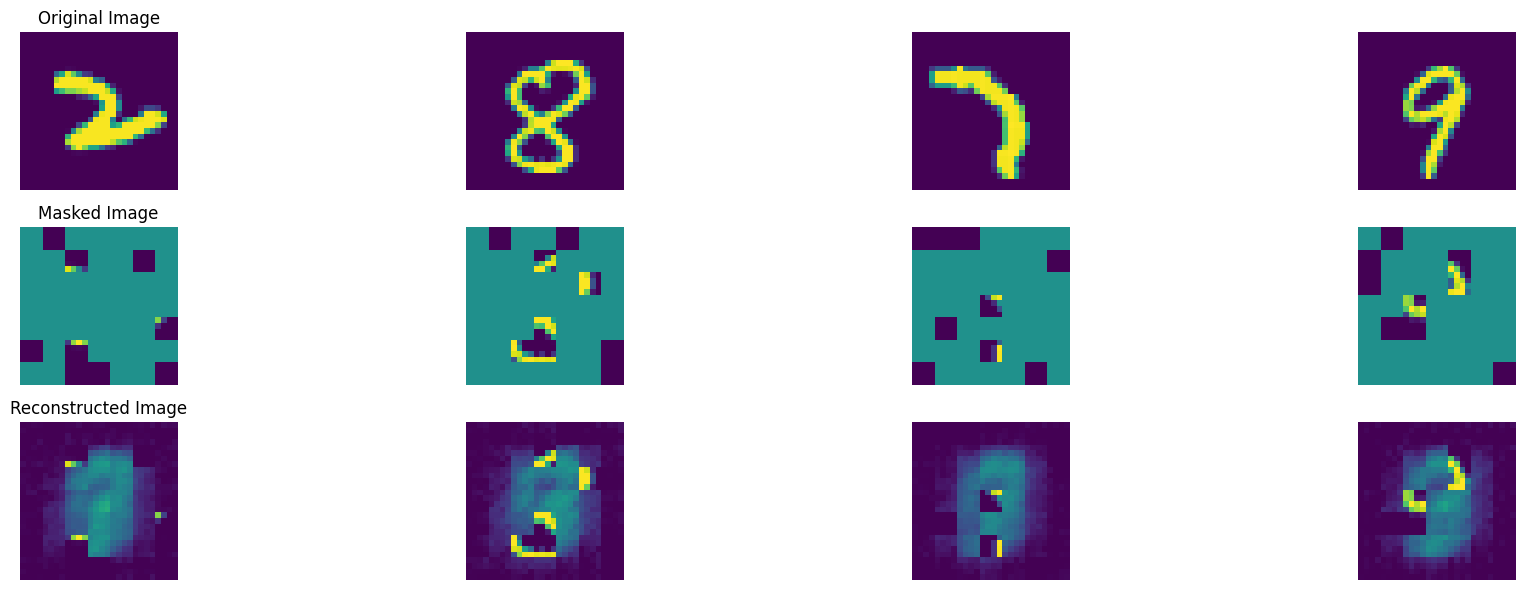

100%|██████████| 188/188 [00:13<00:00, 14.03it/s]


In epoch 5, average traning loss is 0.2697553132125672.
=================== EPOCH:  6  ===================


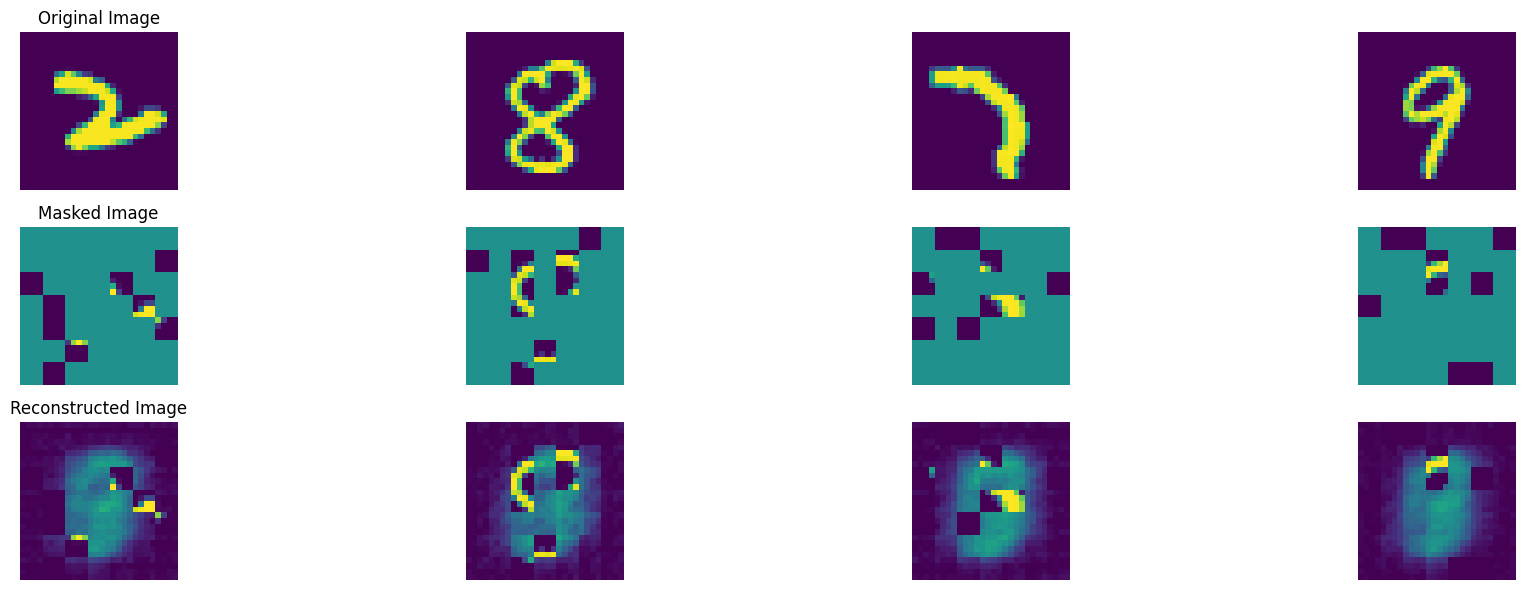

100%|██████████| 188/188 [00:13<00:00, 13.78it/s]


In epoch 6, average traning loss is 0.267296017484462.
=================== EPOCH:  7  ===================


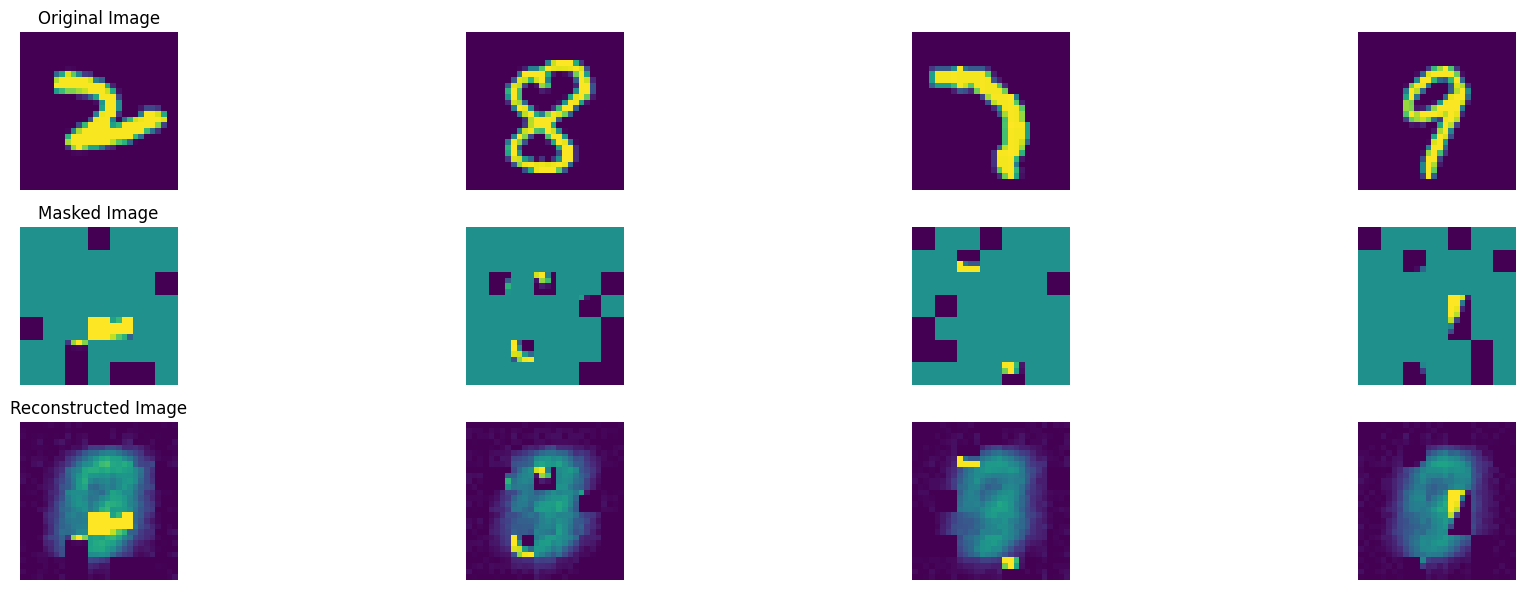

100%|██████████| 188/188 [00:14<00:00, 12.65it/s]


In epoch 7, average traning loss is 0.26577108955763756.
=================== EPOCH:  8  ===================


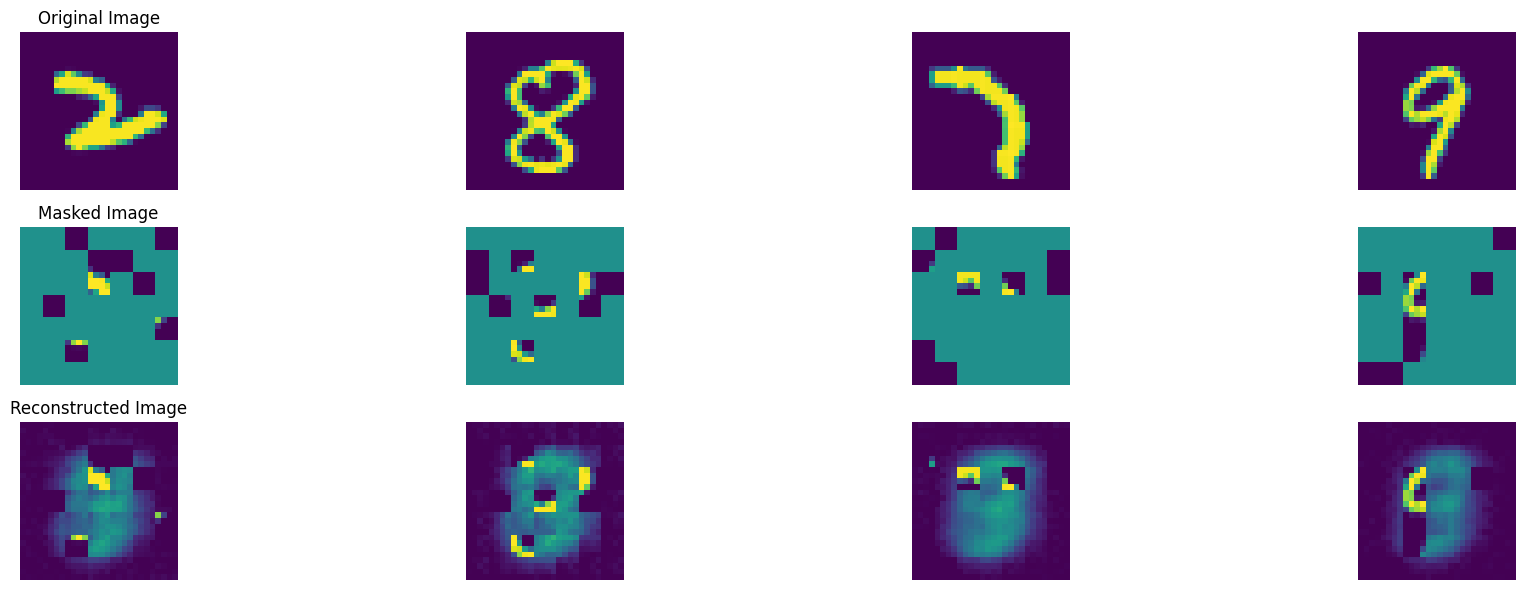

100%|██████████| 188/188 [00:13<00:00, 13.49it/s]


In epoch 8, average traning loss is 0.2647874166673802.
=================== EPOCH:  9  ===================


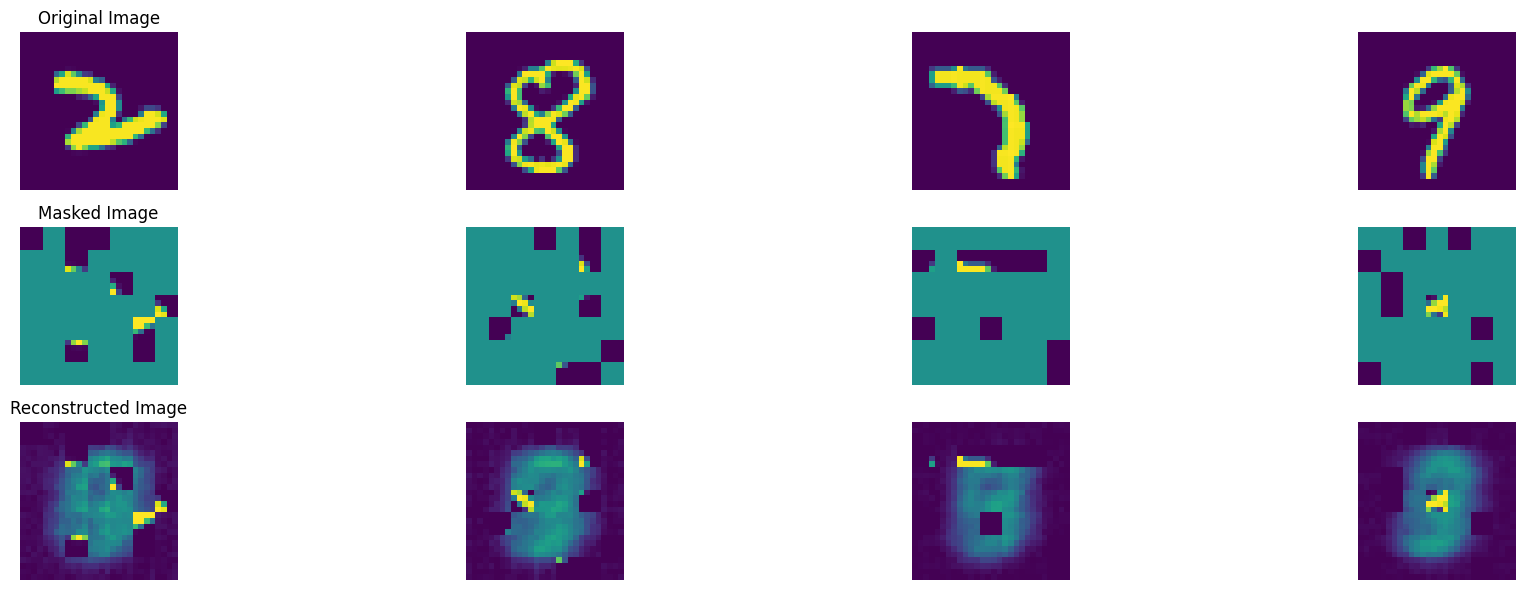

100%|██████████| 188/188 [00:14<00:00, 13.03it/s]


In epoch 9, average traning loss is 0.2638680625786173.
=================== EPOCH:  10  ===================


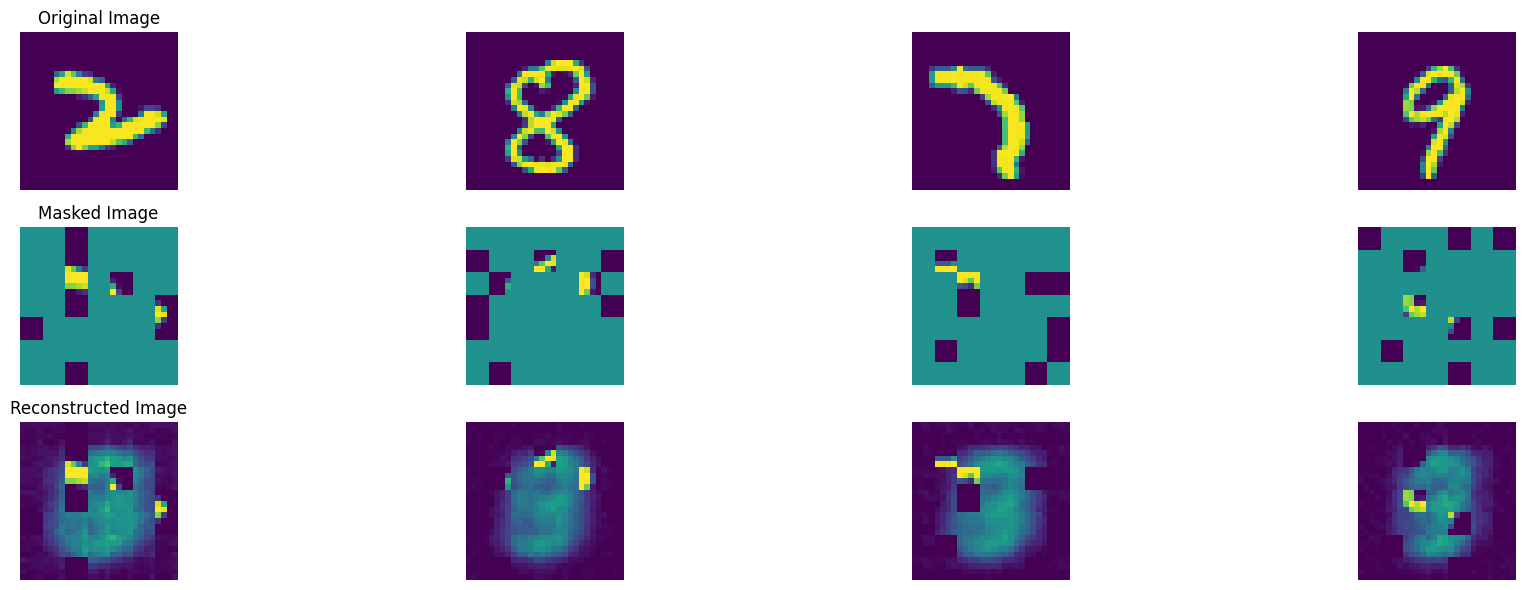

In [7]:
# GPU 6660MiB
import matplotlib.pyplot as plt
step_count = 0
optim.zero_grad()
for e in range(total_epoch):
    model.train()
    losses = []
    for img, label in tqdm(iter(dataloader)):
        step_count += 1
        img = img.to(device)
        predicted_img, mask = model(img)
        loss = torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
        loss.backward()
        if step_count % steps_per_update == 0:
            optim.step()
            optim.zero_grad()
        losses.append(loss.item())
    lr_scheduler.step()
    avg_loss = sum(losses) / len(losses)
    writer.add_scalar('mae_loss', avg_loss, global_step=e)
    print(f'In epoch {e}, average traning loss is {avg_loss}.')
    
    model.eval()
    with torch.no_grad():
        val_img = torch.stack([val_dataset[i][0] for i in range(16)])
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        predicted_val_img = predicted_val_img * mask + val_img * (1 - mask)
        img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
        img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)
        writer.add_image('mae_image', (img + 1) / 2, global_step=e)

        # Inside the visualization block, apply denormalization before displaying
        fig, axes = plt.subplots(3, 4, figsize=(20, 6))
        print("=================== EPOCH: ", e+1, " ===================")
        for i in range(4):
            # Denormalize and clip to [0, 1] for safe visualization
            original_img = denormalize(val_img[i]).clamp(0, 1)
            masked_img = denormalize(val_img[i] * (1 - mask[i])).clamp(0, 1)
            reconstructed_img = denormalize(predicted_val_img[i]).clamp(0, 1)
        
            # Original Image
            axes[0, i].imshow(original_img.permute(1, 2, 0).cpu().numpy())
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title("Original Image")
        
            # Masked Image
            axes[1, i].imshow(masked_img.permute(1, 2, 0).cpu().numpy())
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title("Masked Image")
        
            # Reconstructed Image
            axes[2, i].imshow(reconstructed_img.permute(1, 2, 0).cpu().numpy())
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_title("Reconstructed Image")
        plt.tight_layout()
        plt.show()
        
    ''' save model '''
    torch.save(model, model_path)

### Exercises
1) With MNIST dataset, experiment with different patch_sizes, masking ratio on the reconstruction part. Describe what you have learnt

Here is my best results, see if you can beat me

The original images
<img src="img/MAE_original.png" title="MAE - Original" style="width: 1080px;" />

My reconstructed images
<img src="img/MAE_recon.png" title="MAE - recon" style="width: 1080px;" />

2) Now since we have trained our MAE. Let's make use of it!

Once the autoencoder is trained, the learned encoder can be repurposed for downstream tasks like image classification.

**How It Works:**

Encoder Extraction: After pretraining, the encoder is detached from the decoder and fine-tuned for classification.

Class Token Addition: A classification token (CLS) is added to the input patch sequence. This token interacts with other patches during encoding and aggregates the final representation.

Linear Classifier: A linear classifier (MLP head) is attached on top of the encoder to map the latent representation to class labels.

With MNIST dataset, train a classifier (Part2)and report results. (Classifier class is already given below)


## Transition to a downstream task

In [ ]:
class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits

3) Experiment with a different dataset, CIFAR-10. Discuss the similarity and differences of the results of both datasets. Suggest possible improvements you could potentially make to CIFAR-10 in the future.

### The report
Describe your experiments and their results. The report should be turned in on Teal Classroom before the deadline.